In [11]:
import os
os.chdir('../data')
######### **1.1** Adding Libraries

import pandas as pd
import numpy as np
import sys
import pickle
pd.options.mode.chained_assignment = None
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 14,}
from scipy.stats import mode
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
import seaborn as sns
le = preprocessing.LabelEncoder()
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
################# -------------- read holiday ----------------- #############

cust_ret_data_h=pd.read_csv("repurchaseQ2-Copy1.txt",encoding='latin-1')
main_data_h=pd.read_csv("repurchaseQ1-Copy1.txt",encoding='latin-1',low_memory=False)
RFM_data_h=pd.read_csv("RFM_holiday.csv",encoding='latin-1',low_memory=False)
cust_data_h=pd.read_csv("cust_data_holiday.csv",encoding='latin-1',low_memory=False)

################# -------------- read non_holiday ----------------- #############

cust_ret_data_nh=pd.read_csv("Query2July_Oct.csv",encoding='latin-1',low_memory=False)
main_data_nh=pd.read_csv("Query1July_Oct.csv",encoding='latin-1',low_memory=False)
RFM_data_nh=pd.read_csv("RFM_non_holiday.csv",encoding='latin-1',low_memory=False)
cust_data_nh=pd.read_csv("cust_data_non_holiday.csv",encoding='latin-1',low_memory=False)

In [12]:
from macys_rep_transformation import *

In [14]:
final_h=arrange(main_data_h)   ###### loading transformed data of holidays ######
final_nh=arrange(main_data_nh)    ###### loading transformed data of Non_holidays ######

NameError: name 'pd' is not defined

In [194]:
import os
os.getcwd()

'/home/daasml/Repurchase/data'

### Data transformation ##

In [3]:
def arrange(main_data):
    main_data['cid']=main_data.cid.astype("str")
    main_data['upc']=main_data.upc.astype("str")

    for col in['r_dt','r_amt','prc','qty','amt','r_qty','dt']:
        main_data[col].replace("(null)",'',inplace=True)

    for col in ['r_qty','r_amt','amt','qty','prc']:      
        main_data[col]=pd.to_numeric(main_data[col])
    main_data.drop(['MDSE_DEPT_NBR','BUYER_ID','PARENT_MDSE_DIVN_ID','GMM_ID'],axis=1,inplace=True)
    main_data['dt'] = pd.to_datetime(main_data['dt'])         ### change the date format ##
    main_data['r_dt'] = pd.to_datetime(main_data['r_dt'])
    count_data = main_data.groupby(['cid','upc']).size().reset_index(None) ## grouping the data by cid,upc & taken only two transactions(for same cid,same upc)##
    count_data.columns = ['cid','upc','count']
    count_2 = count_data[count_data['count']==2]
    ids = count_2.cid+'_'+count_2.upc
    main_data['new_id'] = main_data.cid+"_"+main_data.upc
    main_data_new = main_data.loc[main_data.new_id.isin(ids)]
    print("shape of data after taking count as 2",main_data_new.shape)

    main_data_new = main_data_new.sort_values(by=['cid','upc','dt']).reset_index(None) ## sorting ##
    main_data_new_copy = main_data_new.copy(deep=True)                                ### taking copy of the sorted data , in order to shift one row above ##
    main_data_new_copy = main_data_new_copy.shift(-1)

    main_data_new_copy.rename(columns={'r_dt':'r_dt_new','prc':'prc_new','amt':'amt_new','r_qty':'r_qty_new','amt':'amt_new',
                                       'oid':'oid_new','qty':'qty_new','r_amt':'r_amt_new','dt':'buy_dt_new'},inplace=True)
    main_data_new.rename(columns={'r_dt':'r_dt_old','prc':'prc_old','amt':'amt_old','r_qty':'r_qty_old','amt':'amt_old',
                                  'oid':'oid_old','qty':'qty_old','r_amt':'r_amt_old','dt':'buy_dt_old'},inplace=True)
    main_data_new.drop(['GMM_DESC','PROD_TYP_DESC','PARENT_MDSE_DIVN_DESC'],axis=1,inplace=True)
    main_data_new_copy.drop(['cid','upc'],axis=1,inplace= True)
    final = pd.concat([main_data_new,main_data_new_copy],axis=1)
    final=final.reset_index()
    del_cols = ['index','new_id']
    final.drop(del_cols,axis=1,inplace=True)
    final = final.iloc[::2]
    print("shape of the sales data after transformation",final.shape)

    #################------------------------- Deriving variables ------------------------------ ####################
    final['time_to_new_purchase']=(final['buy_dt_new']-final['buy_dt_old']).dt.days
    final['prc_chg_dollar']=final['prc_new']-final['prc_old']
    final['prc_chg_pct']=final['prc_chg_dollar']/final['prc_new']
    final['prc_chg_per_day']=final['prc_chg_dollar']/(final['time_to_new_purchase']+1)

    final['return_duration_from_recent_buy']=np.nan
    final['return_status']='N'
    final['returned_old_flag']='N'
    final['return_status_repurchase']=0

    final.loc[(np.isnan(final.r_qty_new) & np.isnan(final.r_qty_old)),['return_status','return_status_repurchase']]=['Both Kept',0]  
    final.loc[(final.r_qty_new>0) & (final.r_qty_old>0),['return_status','return_status_repurchase']] = ['Both Returned',1]
    final.loc[np.isnan(final.r_qty_new) & (final.r_qty_old>=0),['return_status']] = ['Returned Old']
    indexes = final.loc[(final.r_dt_old != "") & (final.buy_dt_new > final.r_dt_old),].index
    final.loc[indexes,'return_duration_from_recent_buy'] = (final.loc[indexes,'r_dt_old']-final.loc[indexes,'buy_dt_new']).dt.days
    final.loc[indexes,'returned_old_flag']="Y"
    final.loc[indexes,'return_status_repurchase']=0

    indexes_not=final.loc[pd.notnull(final.r_dt_old) & (final.buy_dt_new <=final.r_dt_old),].index
    final.loc[indexes_not,'return_duration_from_recent_buy'] = (final.loc[indexes_not,'r_dt_old']-final.loc[indexes_not,'buy_dt_new']).dt.days
    final.loc[indexes_not,'returned_old_flag']="N"
    final.loc[indexes_not,'return_status_repurchase']=1

    final.loc[(final.r_qty_new>=0) & np.isnan(final.r_qty_old),['return_status','return_status_repurchase']]=['Returned_New',1]   
    final.drop(['return_status','return_duration_from_recent_buy','PROD_TYP_DESC','PROD_DESC','BRND_NM','VND_NM','BUYER_DESC',
                'MDSE_DEPT_DESC','LBL_NM'],axis=1,inplace=True)
    
    return(final)


In [4]:
final_h=arrange(main_data_h)   ###### loading transformed data of holidays ######
final_nh=arrange(main_data_nh)    ###### loading transformed data of Non_holidays ######

shape of data after taking count as 2 (665544, 21)
shape of the sales data after transformation (332772, 36)
shape of data after taking count as 2 (993398, 21)
shape of the sales data after transformation (496699, 36)


#### Define function to check destributions ###

In [187]:
def distributions_df(df,df1,df2,df3,df4):
    print(pd.DataFrame({'Sales_Data_before_Transformation':df1.shape,'Sales_data_After_Transformation':df.shape,
                  'RFM_data':RFM_data_h.shape,'Customer_return_history_data':df2.shape,'customer_demographic_data':df4.shape}).reset_index().rename({0:'rows',1:'columns'}).drop('index',axis=1).T)
    print(pd.DataFrame({'Target_distribution_Before_transformation':df1.return_status_repurchase.value_counts(normalize=True),'Target_distribution_After_transformation':df.return_status_repurchase.value_counts(normalize=True)})).reset_index()

    

In [188]:
distributions_df(final_h,main_data_h,cust_ret_data_h,RFM_data_h,cust_data_h)

                                     rows  columns
Customer_return_history_data      1967689        9
RFM_data                           210658       15
Sales_Data_before_Transformation   816550       21
Sales_data_After_Transformation    326783       29
customer_demographic_data          124723        4


AttributeError: 'DataFrame' object has no attribute 'return_status_repurchase'

In [5]:
def distribution(df,df1,df2,df3,df4):
    
    #print("~~~~~~~~~~~~~~~~~~For holiday data~~~~~~~~~~~~~~~~~~~~~~~")
    print("Target distribution"+"\n", df.return_status_repurchase.value_counts(normalize=True))
    print("Sales Data before tansformation\n \t # Rows: ",df1.shape[0],"\n \t # Columns : ",df1.shape[1])
    print("Sales Data Transformed\n ","\t# Rows: ",df.shape[0],"\n\t# Columns : ",df.shape[1])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Shape of customer return history is\n,\t# Rows: ",df2.shape[0],"\n\t# Columns : ",df2.shape[1])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Shape of RFM_data is\n,\t# Rows: ",df3.shape[0],"\n\t# Columns : ",df3.shape[1])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Shape of Customer data\n,\t# Rows: ",df4.shape[0],"\n\t# Columns : ",df4.shape[1])
    #print("~~~~~~~~~~~~~~~~~Non_holiday data~~~~~~~~~~~~~~~~~~~~~~~")
    
distribution(final_h,main_data_h,cust_ret_data_h,RFM_data_h,cust_data_h)
distribution(final_nh,main_data_nh,cust_ret_data_nh,RFM_data_nh,cust_data_nh)

  

Target distribution
 1    0.513382
0    0.486618
Name: return_status_repurchase, dtype: float64
Sales Data before tansformation
 	 # Rows:  816550 
 	 # Columns :  21
Sales Data Transformed
  	# Rows:  332772 
	# Columns :  29
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of customer return history is
,	# Rows:  1974922 
	# Columns :  7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of RFM_data is
,	# Rows:  211573 
	# Columns :  90
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of Customer data
,	# Rows:  191781 
	# Columns :  80
Target distribution
 0    0.568803
1    0.431197
Name: return_status_repurchase, dtype: float64
Sales Data before tansformation
 	 # Rows:  1567480 
 	 # Columns :  21
Sales Data Transformed
  	# Rows:  496699 
	# Columns :  29
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of customer return history is
,	# Rows:  10901802 
	# Columns :  7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of RFM_data is
,	# Rows:  279981 
	# Columns :  90
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of Customer data
,	# Rows:  2

#### List of observations


In [ ]:
# df=final_h
# df2=cust_ret_data
# df3=RFM_data_h
# df4=cust_data
# df1=sales_data_before_transformation(main_data_h)


In [6]:
def observations(df,df2,df3):
    print("\n"+'No of instances', df2.loc[df2.TOT_BUY_AMT < df2.TOT_RET_AMT,['TOT_BUY_AMT','TOT_RET_AMT']].shape[0])
    #print(df2.loc[df2.TOT_BUY_AMT < df2.TOT_RET_AMT,['TOT_BUY_AMT','TOT_RET_AMT']].head(2))

    print("\n--------Buy_Qty is lower than Ret_Qty---------")
    print("\n"+'No of instances',df2.loc[df2.TOT_BUY_QTY < df2.TOT_RET_QTY,['TOT_BUY_QTY','TOT_RET_QTY']].shape[0])
    #print(df2.loc[df2.TOT_BUY_QTY < df2.TOT_RET_QTY,['TOT_BUY_QTY','TOT_RET_QTY']].head(2))

    print("\n--------In some cases TOT_BUY_AMT is zero---------")
    print("\n"+'  No of instances', df2[(df2[['TOT_BUY_AMT']]==0).all(axis=1)].shape[0])
    #print(df2[(df2[['TOT_BUY_AMT']]==0).all(axis=1)].head(2))

    print("\n----- In some cases amt_new == 0 -----")
    print( 'No of instances', df.loc[df.amt_new==0,'amt_new'].shape)
    #print(df.loc[df.amt_new==0,['amt_new']].head(2))

    print("----- In some cases RFM_SEG_IND == 0 -----")
    print( ""+'No of instances'+"\n",df3.loc[df3['RFM_SEG_IND']==0,].shape)
    #print(df3.loc[df3['RFM_SEG_IND']==0,['RFM_SEG_IND']].head(2))
    
observations(final_h,cust_ret_data_h,RFM_data_h)
observations(final_nh,cust_ret_data_nh,RFM_data_nh)


No of instances 10926
     TOT_BUY_AMT  TOT_RET_AMT
33         73.50       110.99
550       383.13       597.25

--------Buy_Qty is lower than Ret_Qty---------

No of instances 7189
      TOT_BUY_QTY  TOT_RET_QTY
1419            1            2
1503            1            6

--------In some cases TOT_BUY_AMT is zero---------

  No of instances 52
        INDIV_ID  TOT_BUY_COUNT  TOT_BUY_QTY  TOT_BUY_AMT  TOT_RET_COUNT  \
306608  76332117              1            1          0.0              2   
309820  53904521              1            1          0.0              1   

        TOT_RET_QTY  TOT_RET_AMT  
306608            2         68.0  
309820            1        139.0  

----- In some cases amt_new == 0 -----
No of instances (501,)
      amt_new
3272      0.0
4062      0.0
----- In some cases RFM_SEG_IND == 0 -----
No of instances
 (915, 90)
      RFM_SEG_IND
710           0.0
1653          0.0

No of instances 182805
    TOT_BUY_AMT  TOT_RET_AMT
42        20.39        52.98
56   

#### Pre - process steps :

In [7]:
def select_columns_RFM(df3):
    
 ## ------------ from RFM_data ------------###
   
    df3=df3[['R_SCR_NBR','F_SCR_NBR','M_SCR_NBR','INDIV_ID','RFM_SEG_IND','FRST_PURCH_DT','LST_PURCH_DT','DIST_TO_STR_RESID_NBR','ONLN_PURCH_AMT','ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT','STR_FRST_PURCH_DT','STR_LST_PURCH_DT']] 
    df3.loc[df3.FRST_PURCH_DT=="1-01-01", 'FRST_PURCH_DT'] = "01-01-01"
    df3.loc[df3.FRST_PURCH_DT=="0001-01-01", 'FRST_PURCH_DT'] = "01-01-01"
    
 ## ------------ changing the date format ------------##
    
    dates_consider=['FRST_PURCH_DT','LST_PURCH_DT','STR_LST_PURCH_DT','STR_FRST_PURCH_DT','ONLN_LST_PURCH_DT','ONLN_FRST_PURCH_DT']
   
    for col in dates_consider:
        df3[col]=pd.to_datetime(df3[col])
        
    col=['RFM_SEG_IND','R_SCR_NBR','F_SCR_NBR','M_SCR_NBR']
    for col in col:
        df3=df3.loc[df3[col]!=0,] 
    print("Shape of cleaned RFM_data",df3.shape[0])
    
 ## ------------ derived variables from RFM_data ------------###

    df3['lifetime'] = (df3['LST_PURCH_DT'] - df3['FRST_PURCH_DT']).dt.days
    df3['online_lifetime'] = (df3['ONLN_LST_PURCH_DT'] - df3['ONLN_FRST_PURCH_DT']).dt.days
    return df3

RFM_data_h=select_columns_RFM(RFM_data_h) 
RFM_data_nh=select_columns_RFM(RFM_data_nh)

def select_columns_cust(df4):
    
    ## ------------from customer_demographic data------------###
    
    df4=df4[['INDIV_ID','GNDR_CD','DOB_DT']]### selecting only 3-columns form customer data ##
    df4.dropna(subset=['GNDR_CD','DOB_DT','INDIV_ID'],inplace=True,how='any')
    df4['DOB_DT'] = pd.to_datetime(df4['DOB_DT']) ## convert DOB_DT into date format ##
    
    ############# ------------- Derive variables ------------- ###########
    
    df4['Age_Calculated'] = df4['DOB_DT'].apply(lambda born: (dt.date.today().year - born.year - ((dt.date.today().month, dt.date.today().day) < (born.month, born.day))))
    return df4
    

    

cust_data_h=select_columns_cust(cust_data_h)
cust_data_nh=select_columns_cust(cust_data_nh)

print(cust_data_h.shape)
print(cust_data_h.columns)

Shape of cleaned RFM_data 210658
Shape of cleaned RFM_data 279424
(124723, 4)
Index(['INDIV_ID', 'GNDR_CD', 'DOB_DT', 'Age_Calculated'], dtype='object')


##### remove outliers 

In [8]:
#### --------------- removing outliers from customer_return_data ---------------- #####
def remove_outliers(df2):
    df2=df2[(df2[['TOT_BUY_AMT']]!=0).all(axis=1)]
    df2=df2.loc[df2.TOT_BUY_QTY >= df2.TOT_RET_QTY,]
    df2=df2.loc[df2.TOT_BUY_COUNT <= 8000,]           ###3 Here, we are removing around 663 rows ###
    df2['per_Diff_Qty']= df2.TOT_RET_QTY/df2.TOT_BUY_QTY  
    df2['per_Diff_Amt'] =  df2.TOT_RET_AMT/df2.TOT_BUY_AMT 
    return df2

cust_ret_data_h=remove_outliers(cust_ret_data_h)
cust_ret_data_nh=remove_outliers(cust_ret_data_nh)

print(cust_ret_data_h.shape)
print(cust_ret_data_nh.shape)

def remove_outliers_sales(df):
    df=df[(df[['amt_new']]!=0).all(axis=1)]
    df=df[(df[['PARENT_MDSE_DIVN_DESC']]!='(null)').all(axis=1)]
    df=df[(df[['GMM_DESC']]!='(null)').all(axis=1)]
    print("shape sales data after removing outliers",df.shape)
    return df

final_h=remove_outliers_sales(final_h)
final_nh=remove_outliers_sales(final_nh)

(1967689, 9)
(10798624, 9)
shape sales data after removing outliers (326783, 29)
shape sales data after removing outliers (494545, 29)


#### data distribution after cleaning the data (before merging)

In [9]:
distribution(final_h,main_data_h,cust_ret_data_h,RFM_data_h,cust_data_h)
distribution(final_nh,main_data_nh,cust_ret_data_nh,RFM_data_nh,cust_data_nh)


Target distribution
 1    0.513374
0    0.486626
Name: return_status_repurchase, dtype: float64
Sales Data before tansformation
 	 # Rows:  816550 
 	 # Columns :  21
Sales Data Transformed
  	# Rows:  326783 
	# Columns :  29
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of customer return history is
,	# Rows:  1967689 
	# Columns :  9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of RFM_data is
,	# Rows:  210658 
	# Columns :  15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of Customer data
,	# Rows:  124723 
	# Columns :  4
Target distribution
 0    0.568955
1    0.431045
Name: return_status_repurchase, dtype: float64
Sales Data before tansformation
 	 # Rows:  1567480 
 	 # Columns :  21
Sales Data Transformed
  	# Rows:  494545 
	# Columns :  29
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of customer return history is
,	# Rows:  10798624 
	# Columns :  9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of RFM_data is
,	# Rows:  279424 
	# Columns :  15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shape of Customer data
,	# Rows:  20

##### Data Merging ############

In [10]:
final_h['cid']=final_h['cid'].astype("int64")
tot_data_h = pd.merge(final_h, cust_ret_data_h,left_on='cid', right_on='INDIV_ID', how='inner')
tot_data_h.dropna(subset=['INDIV_ID','per_Diff_Qty','per_Diff_Amt','prc_chg_pct'],inplace=True,how='any') 
tot_data1_h=pd.merge(tot_data_h,RFM_data_h,left_on='cid', right_on='INDIV_ID', how='inner')
tot_data2_h=pd.merge(tot_data1_h,cust_data_h,left_on='cid', right_on='INDIV_ID', how='inner')


final_nh['cid']=final_nh['cid'].astype("int64")
tot_data_nh = pd.merge(final_nh, cust_ret_data_nh,left_on='cid', right_on='INDIV_ID', how='inner')
tot_data_nh.dropna(subset=['INDIV_ID','per_Diff_Qty','per_Diff_Amt','prc_chg_pct'],inplace=True,how='any') 
tot_data1_nh=pd.merge(tot_data_nh,RFM_data_nh,left_on='cid', right_on='INDIV_ID', how='inner')
tot_data2_nh=pd.merge(tot_data1_nh,cust_data_nh,left_on='cid', right_on='INDIV_ID', how='inner')


In [11]:
cust_ret_data_nh.shape

(10798624, 9)

In [12]:
def drop_columns(data):
    data.drop(['level_0','TOT_RET_AMT','TOT_BUY_AMT','TOT_BUY_QTY','TOT_RET_QTY','r_amt_new','r_qty_new',
                'r_dt_new','r_dt_old','r_qty_old','r_amt_old','buy_dt_old','buy_dt_new','PROD_TYP_DESC',
                'prc_chg_pct','INDIV_ID','INDIV_ID_x','STR_FRST_PURCH_DT','STR_LST_PURCH_DT','cid','upc',
                'oid_old','web_prod_id','oid_new','INDIV_ID','ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT','LST_PURCH_DT',
                'FRST_PURCH_DT','DOB_DT','INDIV_ID_y'],axis=1,inplace=True)
    return data

data_h=drop_columns(tot_data2_h)
data_nh=drop_columns(tot_data2_nh)
### -------------------------------- for holiday ---------------------------------- ####
print("Shape of data after mearging sales data with cust_hist_data",tot_data_h.shape)
print("shape of data, after merging sales & cust_hist_data with RFM_data",tot_data1_h.shape)
print("shape of data, after merging sales,customer_return_data & RFM_data with customer_data",data_h.shape)
print("shape of RFM_data",RFM_data_h.shape)

### -------------------------------- for non_holiday ---------------------------------- ####
print("\n------- for Non holiday ------\n")

print("Shape of data after mearging sales data with cust_hist_data",tot_data_nh.shape)
print("shape of data, after merging sales & cust_hist_data with RFM_data",tot_data1_nh.shape)
print("shape of data, after merging sales,customer_return_data & RFM_data with customer_data",data_nh.shape)
print("shape of RFM_data",RFM_data_nh.shape)


Shape of data after mearging sales data with cust_hist_data (236435, 38)
shape of data, after merging sales & cust_hist_data with RFM_data (234639, 53)
shape of data, after merging sales,customer_return_data & RFM_data with customer_data (150570, 27)
shape of RFM_data (210658, 15)

------- for Non holiday ------

Shape of data after mearging sales data with cust_hist_data (419667, 38)
shape of data, after merging sales & cust_hist_data with RFM_data (394384, 53)
shape of data, after merging sales,customer_return_data & RFM_data with customer_data (317768, 27)
shape of RFM_data (279424, 15)


#### Special case

In [13]:
print(len(data_h.PARENT_MDSE_DIVN_DESC.unique()))   #### to know the level-count of PARENT_MDSE_DIVN_DESC "
data_h=data_h.loc[(data_h.PARENT_MDSE_DIVN_DESC !='GIFT WRAP EXTRAS') & (data_h.PARENT_MDSE_DIVN_DESC !='WORKSHOP AT MACYS') ,]

21


In [14]:
def drop_nan(dt):
    dt.dropna(subset=['R_SCR_NBR','F_SCR_NBR','M_SCR_NBR','RFM_SEG_IND','ONLN_PURCH_AMT','lifetime','online_lifetime'],inplace=True,how='any')
    return dt

data_h=drop_nan(data_h)
data_nh=drop_nan(data_nh)

##### Distribution plot of Target Variable

In [15]:
def target_dist(dt):
    dt.groupby("return_status_repurchase").size().plot(kind='bar',figsize=(4,4),color=['#FF6D31','#29A2C6'],width=0.2)
    plt.title('Return_Count',size=20,fontname="Arial",fontweight="bold")
    plt.xticks([0,1],['No','Yes'],rotation='0',size=12)
    plt.yticks(rotation='0',size=12)
    plt.xlabel('Return_Category',size=15)
    plt.ylabel('Count',size=15)
    plt.title('Count of Returns',size=20,fontweight="bold")
    plt.show()
# plt.tight_layout()
# plt.savefig("target_dist_h.png")

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


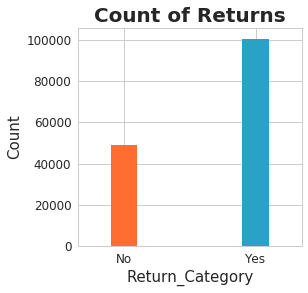

In [16]:
target_dist(data_h)

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


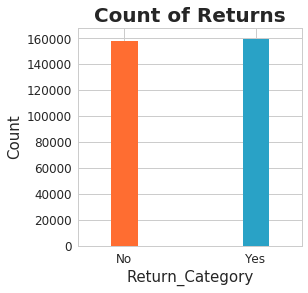

In [17]:
target_dist(data_nh)

##### Create dummies

In [18]:
def dummies(dt):
    cat_var=['GNDR_CD','GMM_DESC','returned_old_flag','PARENT_MDSE_DIVN_DESC','RFM_SEG_IND','R_SCR_NBR','F_SCR_NBR','M_SCR_NBR']
    dt=pd.get_dummies(dt,columns=cat_var)
    dt['return_status_repurchase']=dt.return_status_repurchase.astype('object')
    return dt

data_h_d=dummies(data_h)
data_nh_d=dummies(data_nh)

In [19]:
data_h_d.shape

(149864, 70)

### Split into test and train

In [ ]:
def tr

In [27]:
data_h_d['return_status_repurchase'] = le.fit_transform(data_h_d['return_status_repurchase'])
X_h = data_h_d.drop('return_status_repurchase',axis=1)
y_h = data_h_d['return_status_repurchase']
X_train_holiday, X_test_holiday, y_train_holiday, y_test_holiday = train_test_split(X_h,y_h,test_size=0.2, random_state=42)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("train_data_shape",X_train_holiday.shape)
print("test_data_shape",X_test_holiday.shape)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("test_distribution of target", "\n 1 : ",y_test_holiday.sum()/y_test_holiday.size,"\n 0 : ",1-(y_test_holiday.sum()/y_test_holiday.size))
print("train_distribution of target","\n 1 : ",y_train_holiday.sum()/y_train_holiday.size,"\n 0 : ",1-(y_train_holiday.sum()/y_train_holiday.size) )

data_nh_d['return_status_repurchase'] = le.fit_transform(data_nh_d['return_status_repurchase'])
X_nh = data_nh_d.drop('return_status_repurchase',axis=1)
y_nh = data_nh_d['return_status_repurchase']
X_train_Non_holiday, X_test_Non_holiday, y_train_Non_holiday, y_test_Non_holiday = train_test_split(X_nh,y_nh,test_size=0.2, random_state=42)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("train_data_shape",X_train_Non_holiday.shape)
print("test_data_shape",X_test_Non_holiday.shape)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("test_distribution of target", "\n 1 : ",y_test_Non_holiday.sum()/y_test_Non_holiday.size,"\n 0 : ",1-(y_test_Non_holiday.sum()/y_test_Non_holiday.size))
print("train_distribution of target","\n 1 : ",y_train_Non_holiday.sum()/y_train_Non_holiday.size,"\n 0 : ",1-(y_train_Non_holiday.sum()/y_train_Non_holiday.size) )



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train_data_shape (119891, 69)
test_data_shape (29973, 69)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

test_distribution of target 
 1 :  0.6747072365128616 
 0 :  0.3252927634871384
train_distribution of target 
 1 :  0.672927909517812 
 0 :  0.327072090482188

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train_data_shape (254204, 69)
test_data_shape (63551, 69)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

test_distribution of target 
 1 :  0.5037843621658196 
 0 :  0.49621563783418043
train_distribution of target 
 1 :  0.5034303158093499 
 0 :  0.49656968419065006


In [ ]:
def check_distribution()

#### Model 

In [ ]:
# def Train_model(X_train,y_train,model_name):
#     model_gbm =GradientBoostingClassifier(random_state=55,n_estimators=50,learning_rate=0.05,max_depth=6)
#     model_gbm.fit(X_train,y_train)   
#     with open('/home/daasml/Repurchase/final_repurchase_results/'+model_name+'.sav', 'wb') as fp:
#         pickle.dump(model_gbm,fp)
    

# Train_model(X_train_holiday,y_train_holiday,'holiday_gbm')
# Train_model(X_train_Non_holiday,y_train_Non_holiday,'non_holiday_gbm')

In [28]:
def v_confusion_matrix(confusion_matrix_train,confusion_matrix_test):
    sum_train = confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1]
    sum_test = confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1]
    df_cm_train = confusion_matrix_train/sum_train
    df_cm_test = confusion_matrix_test/sum_test
    
    fig = plt.figure(figsize=(8,8))
    fig, axs = plt.subplots(1,2,figsize=(8,2),squeeze=0)
    
    sns.heatmap(df_cm_train,annot=True,fmt='g',ax=axs[0,0], annot_kws={"size": 20})
    sns.heatmap(df_cm_test,annot=True,fmt='g',ax=axs[0,1], annot_kws={"size": 20})
    plt.subplots_adjust(left=-0.3, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.suptitle('CONFUSION MATRIX',x=0.25,y=1.2,fontweight='bold')
    axs[0,0].set_title("On Train",y=-0.5)
    axs[0,1].set_title("On Test",y=-0.5)
#     print(accuracy_score(actual,predicted))
    
    for i in [0,1]:
        #axs[0,i].set_title("Title for second plot")
        axs[0,i].set_xlabel('Predicted', fontsize = 15)
        axs[0,i].set_ylabel('Actual', fontsize = 15)
        axs[0,i].xaxis.set_tick_params(labelsize=15,labeltop='on',labelbottom='off')
        axs[0,i].yaxis.set_tick_params(labelsize=15)
    plt.show()

def Feature_imp(model,traindata):
    plt.figure(figsize=(13,8))
    feat_imp = pd.Series(model.feature_importances_, traindata.columns).sort_values(ascending=True)
    feat_imp[len(feat_imp)-20:len(feat_imp)].plot(kind='barh', title='Top 20 Features',color='blue')
    plt.title('Top 20 Attributes impacting return_status_repurchase',fontweight='bold',fontsize=18)
    plt.yticks( fontsize=12)
    plt.xticks( fontsize=12)
    plt.show()
    
def roc_cutoffs(model,X,y):
    df=pd.DataFrame()
    i=0
    df['cutoff']=np.arange(0.1,1.0,0.1)
    
    for cutoff in np.arange(0.1,1.0,0.1):
        x = pd.DataFrame(model.predict_proba(X))[1].map(lambda x: 1 if x>cutoff else 0)
        cf=confusion_matrix(y,x)
        TPR = cf[1,1]/(cf[1,1]+cf[1,0])
        FPR = cf[0,1]/(cf[0,0]+cf[0,1])
        df.loc[i,'Accuracy_Score']=accuracy_score(y,x)
        df.loc[i,'TPR']=TPR
        df.loc[i,'FPR']=FPR
        i=i+1
    return df

def roc_curve_plot(model,test_X,test_y):
    plt.figure(figsize=(6,6))
    logit_roc_auc = roc_auc_score(test_y,model.predict(test_X))
    #print('Area under ROC curve is:',logit_roc_auc)
    fpr, tpr, thresholds = roc_curve(test_y,model.predict_proba(test_X)[:,1])
    plt.plot(fpr, tpr, label='GBM (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic',size=20,fontweight="bold")
    plt.legend(loc="lower right")
    plt.tight_layout()
    #plt.savefig('Log_ROC_h_h.png')
    plt.show()

    


    
    

In [23]:
#print(roc_cutoffs(model_gbm_holiday_RFM,X_train_holiday,y_train_holiday))


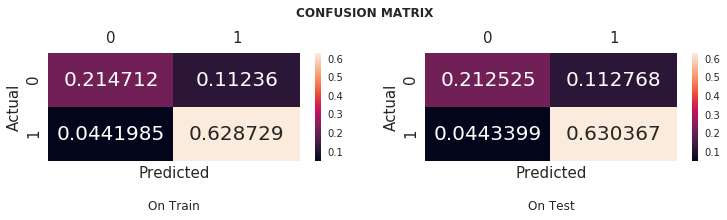


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8434411256891676

 accuracy_on_test :  0.8428919360758016

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.83      0.65      0.73      9750
          1       0.85      0.93      0.89     20223

avg / total       0.84      0.84      0.84     29973


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.83      0.66      0.73     39213
          1       0.85      0.93      0.89     80678

avg / total       0.84      0.84      0.84    119891

-------------------------------
 Feature_Importance plot
--------------------------------


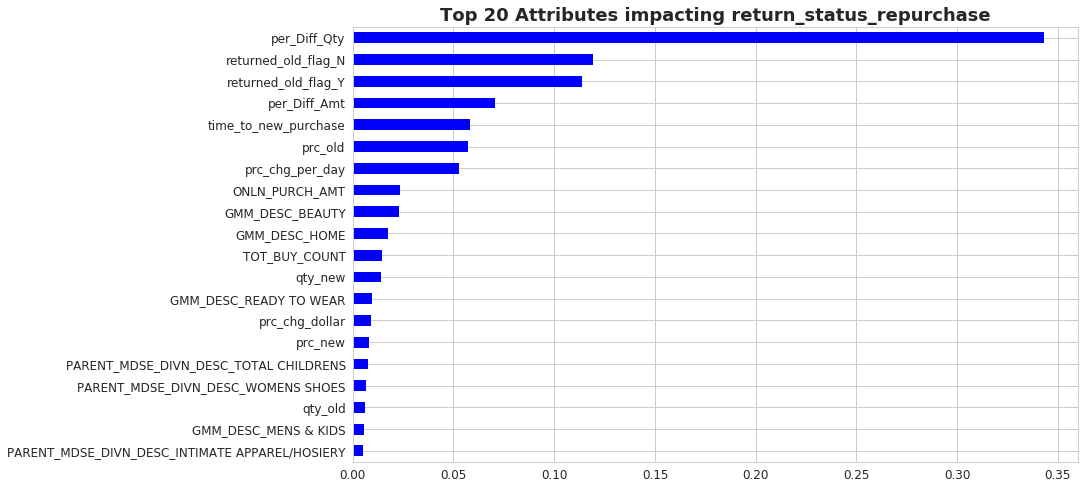

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.722114  1.000000  0.849616
1     0.2        0.779625  0.995786  0.665111
2     0.3        0.815966  0.982015  0.525668
3     0.4        0.835100  0.963013  0.428072
4     0.5        0.843441  0.934319  0.343534
5     0.6        0.841564  0.891445  0.261061
6     0.7        0.821638  0.820211  0.175427
7     0.8        0.761000  0.689618  0.092138
8     0.9        0.580886  0.386437  0.019050


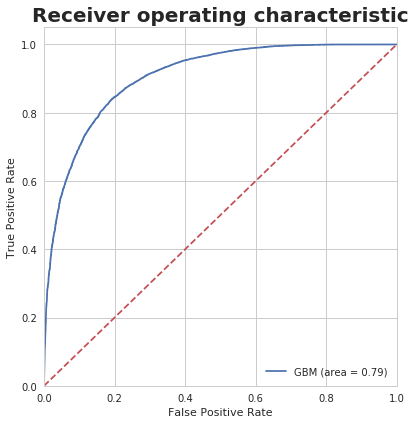

In [29]:
 def model(X_train,y_train,X_test,y_test,train_on='holiday'):
        if(train_on=='holiday'):
            with open('/home/daasml/Repurchase/final_repurchase_results/holiday_gbm.sav', 'rb') as fp:
                model_gbm = pickle.load(fp)
                
        else:
            with open('/home/daasml/Repurchase/final_repurchase_results/non_holiday_gbm.sav', 'rb') as fp:
                model_gbm = pickle.load(fp)
       
       # print("Confusion_matrix",confusion_matrix(y_train,model_gbm.predict(X_train))/(len(X_train)))

      ###################   ----- plot confusion matrix -------  #################################### 

        df_cm_train= confusion_matrix(y_train,model_gbm.predict(X_train))/(len(X_train))
        df_cm_test = confusion_matrix(y_test,model_gbm.predict(X_test))/(len(y_test))
        v_confusion_matrix(df_cm_train,df_cm_test)
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
        print("accuracy_on_train : ",accuracy_score(y_train,model_gbm.predict(X_train)))
        print("\n accuracy_on_test : ", accuracy_score(y_test,model_gbm.predict(X_test)))
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~\n")
        print("\n classification report on Train : \n",classification_report(y_test,model_gbm.predict(X_test)))
        print("\n classification report on Test : \n",classification_report(y_train,model_gbm.predict(X_train)))

        print("-------------------------------\n Feature_Importance plot\n--------------------------------")
        Feature_imp(model_gbm,X_train)
        
         
        print("---------------------------------\n Roc-curve\n--------------------------------------------")
        print(roc_cutoffs(model_gbm,X_train,y_train))
        roc_curve_plot(model = model_gbm,test_X = X_test,test_y = y_test)
            
        
       


In [ ]:
model(X_train_holiday,y_train_holiday,X_test_holiday,y_test_holiday,train_on='holiday')  ### Train : Holiday , Test : Holiday

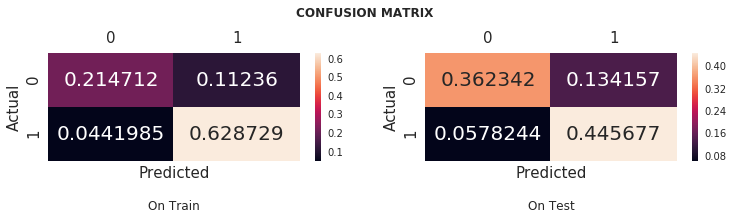


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8434411256891676

 accuracy_on_test :  0.8080187565891961

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.86      0.73      0.79    157765
          1       0.77      0.89      0.82    159990

avg / total       0.82      0.81      0.81    317755


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.83      0.66      0.73     39213
          1       0.85      0.93      0.89     80678

avg / total       0.84      0.84      0.84    119891

-------------------------------
 Feature_Importance plot
--------------------------------


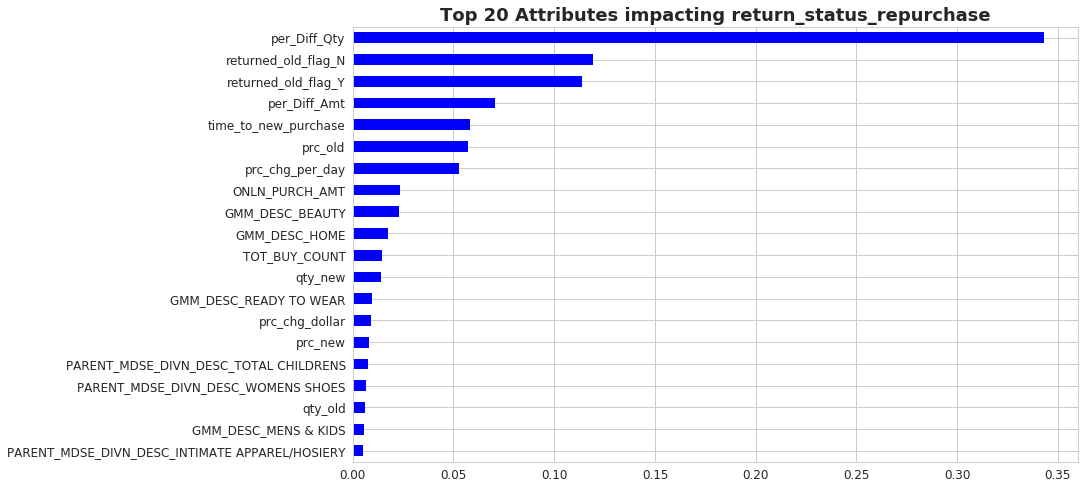

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.722114  1.000000  0.849616
1     0.2        0.779625  0.995786  0.665111
2     0.3        0.815966  0.982015  0.525668
3     0.4        0.835100  0.963013  0.428072
4     0.5        0.843441  0.934319  0.343534
5     0.6        0.841564  0.891445  0.261061
6     0.7        0.821638  0.820211  0.175427
7     0.8        0.761000  0.689618  0.092138
8     0.9        0.580886  0.386437  0.019050


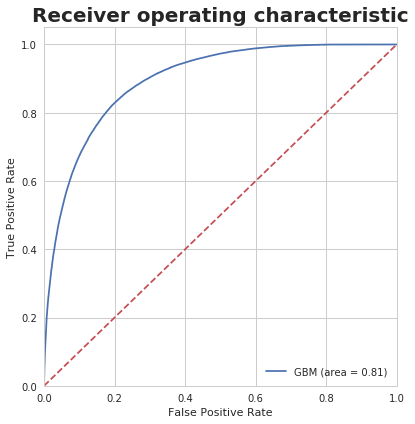

In [32]:
model(X_train_holiday,y_train_holiday,X_nh,y_nh,train_on='holiday') #### Train: Holiday ,Test: Non_holiday 

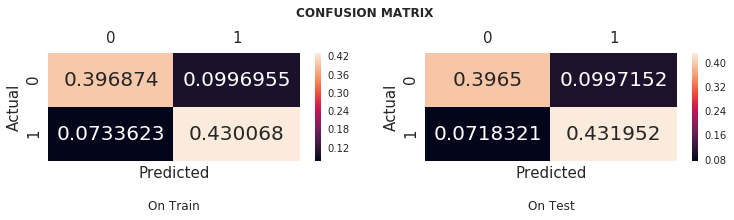


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8269421409576561

 accuracy_on_test :  0.8284527387452597

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.85      0.80      0.82     31535
          1       0.81      0.86      0.83     32016

avg / total       0.83      0.83      0.83     63551


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.84      0.80      0.82    126230
          1       0.81      0.85      0.83    127974

avg / total       0.83      0.83      0.83    254204

-------------------------------
 Feature_Importance plot
--------------------------------


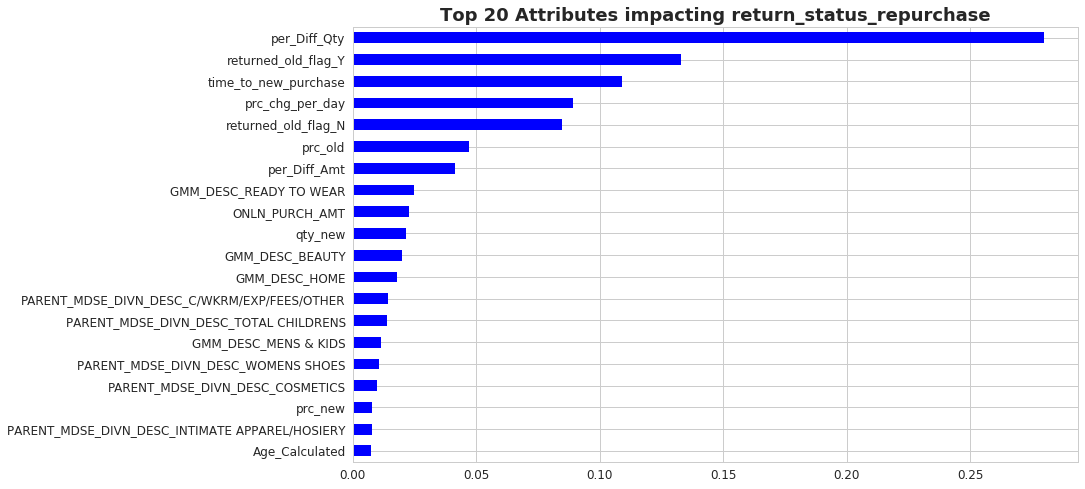

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.635584  0.998914  0.732766
1     0.2        0.746562  0.980691  0.490803
2     0.3        0.794799  0.949263  0.361800
3     0.4        0.818469  0.908825  0.273136
4     0.5        0.826942  0.854275  0.200768
5     0.6        0.820569  0.781784  0.140109
6     0.7        0.792903  0.671332  0.083847
7     0.8        0.721059  0.479050  0.033589
8     0.9        0.535346  0.078289  0.001283


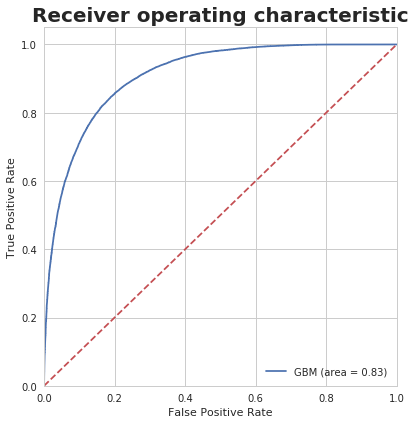

In [33]:
model(X_train_Non_holiday,y_train_Non_holiday,X_test_Non_holiday,y_test_Non_holiday,train_on='non_holiday') #### Train: Non_Holiday ,Test: Non_holiday

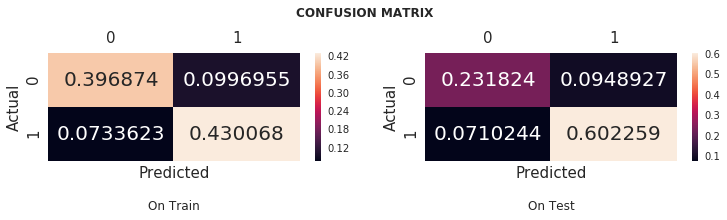


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8269421409576561

 accuracy_on_test :  0.8340829018309934

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.77      0.71      0.74     48963
          1       0.86      0.89      0.88    100901

avg / total       0.83      0.83      0.83    149864


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.84      0.80      0.82    126230
          1       0.81      0.85      0.83    127974

avg / total       0.83      0.83      0.83    254204

-------------------------------
 Feature_Importance plot
--------------------------------


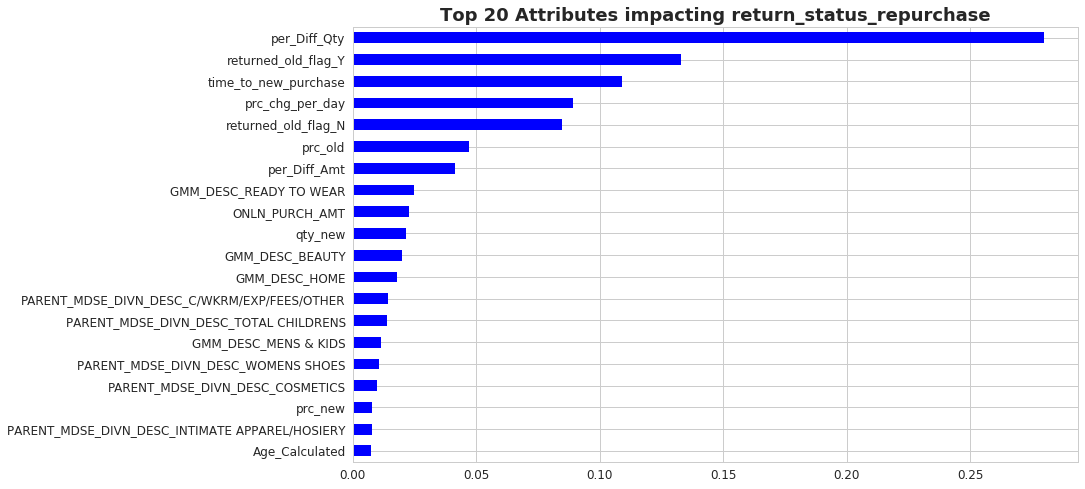

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.635584  0.998914  0.732766
1     0.2        0.746562  0.980691  0.490803
2     0.3        0.794799  0.949263  0.361800
3     0.4        0.818469  0.908825  0.273136
4     0.5        0.826942  0.854275  0.200768
5     0.6        0.820569  0.781784  0.140109
6     0.7        0.792903  0.671332  0.083847
7     0.8        0.721059  0.479050  0.033589
8     0.9        0.535346  0.078289  0.001283


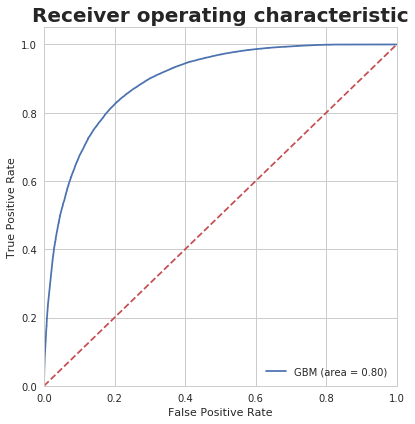

In [34]:
model(X_train_Non_holiday,y_train_Non_holiday,X_h,y_h,train_on='non_holiday')  ## Train : Non-holiday , Test: Holiday

In [ ]:
print(roc_cutoffs(model_gbm,tot_data2[list([x for x in tot_data2.columns if x not in ['return_status_repurchase']])],tot_data2.return_status_repurchase))
plt.figure(figsize=(6,6))
logit_roc_auc = roc_auc_score(tot_data2.return_status_repurchase,model_gbm_non_holiday.predict(tot_data2[list([x for x in tot_data2.columns if x not in ['return_status_repurchase']])]))
#print('Area under ROC curve is:',logit_roc_auc)
fpr, tpr, thresholds = roc_curve(tot_data2.return_status_repurchase,model_gbm_non_holiday.predict_proba(tot_data2[list([x for x in tot_data2.columns if x not in ['return_status_repurchase']])])[:,1])
plt.plot(fpr, tpr, label='GBM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic',size=20,fontweight="bold")
plt.legend(loc="lower right")



In [ ]:
def roc_